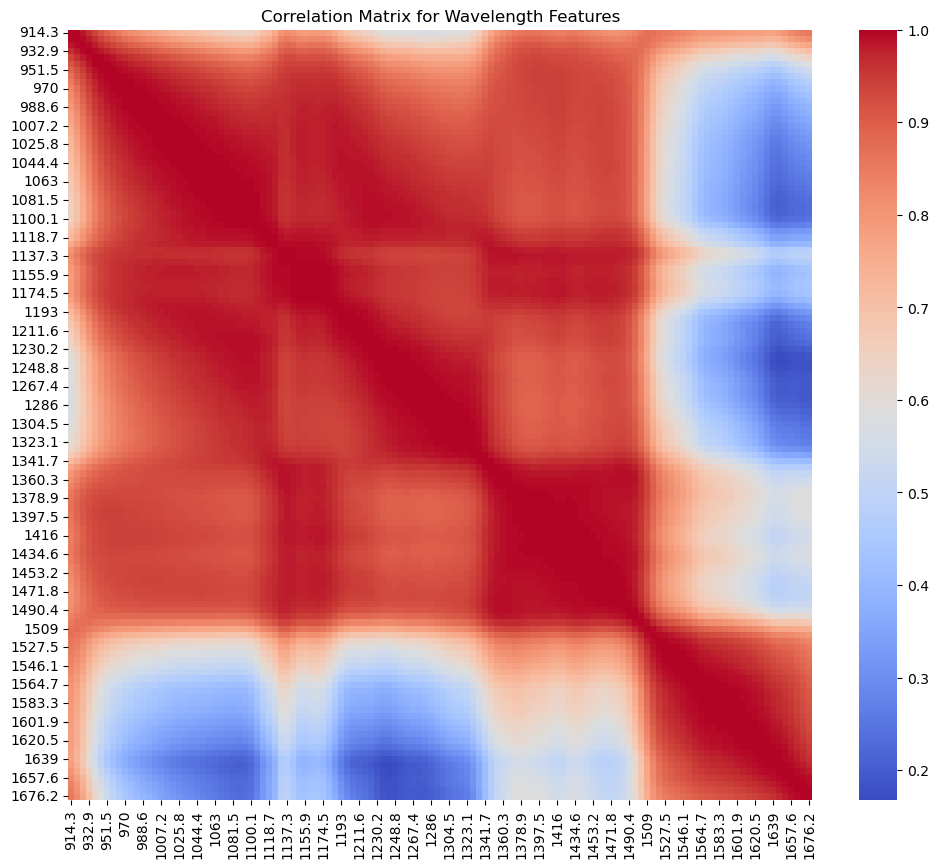

Highly correlated features:
957.7 and 963.8: 0.9992237318434654
963.8 and 970: 0.9994257375286089
970 and 976.2: 0.9995632724166343
976.2 and 982.4: 0.999655318219879
982.4 and 988.6: 0.9997231817435572
988.6 and 994.8: 0.9997552605709509
988.6 and 1001: 0.999043205552688
994.8 and 1001: 0.9997596691924364
994.8 and 1007.2: 0.9990909305085924
1001 and 1007.2: 0.9997797780602713
1001 and 1013.4: 0.9991364863158605
1007.2 and 1013.4: 0.9997836260966732
1007.2 and 1019.6: 0.9991887574747876
1013.4 and 1019.6: 0.9998054216543066
1013.4 and 1025.8: 0.999288433949433
1019.6 and 1025.8: 0.9998326817967871
1019.6 and 1032: 0.9993666715556865
1025.8 and 1032: 0.9998461751036485
1025.8 and 1038.2: 0.9994157658582117
1032 and 1038.2: 0.9998584564051585
1032 and 1044.4: 0.9994602711441726
1038.2 and 1044.4: 0.999868839672761
1038.2 and 1050.6: 0.9994632422532832
1044.4 and 1050.6: 0.9998602603570816
1044.4 and 1056.8: 0.9994631133735605
1050.6 and 1056.8: 0.9998687696802451
1050.6 and 1063: 0.9994

In [13]:

# def knn():
# PURITY log transform  
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt

def preprocessing_v1(apply_one_hot=False, apply_scaling=False, apply_pca=False, apply_correlation=False, apply_remove_outliers=False):
    train_data_og = pd.read_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/train.csv')
    test_data_og = pd.read_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/test.csv')
    train_data = train_data_og.copy()
    test_data = test_data_og.copy()
    train_data = train_data.drop(columns=['prod_substance'])
    test_data = test_data.drop(columns=['prod_substance'])
    
    non_wavelength_cols = ['device_serial', 'substance_form_display', 'measure_type_display']
    wavelength_cols = train_data.columns[6:]
    
    if apply_one_hot:
        # One Hot encoding 
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_train_encoded = encoder.fit_transform(train_data[non_wavelength_cols])
        X_test_encoded = encoder.transform(test_data[non_wavelength_cols])
        
        # Convert encoded features to DataFrame
        X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(non_wavelength_cols))
        X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(non_wavelength_cols))
        
        train_data_combined = pd.concat([pd.DataFrame(X_train_encoded_df), train_data[wavelength_cols].reset_index(drop=True)], axis=1)
        test_data_combined = pd.concat([pd.DataFrame(X_test_encoded_df), test_data[wavelength_cols].reset_index(drop=True)], axis=1)
    else:
        train_data_combined = train_data
        test_data_combined = test_data
    
    # Add sample_name column back to the combined DataFrames
    train_data_combined.insert(0, 'sample_name', train_data_og['sample_name'])
    test_data_combined.insert(0, 'sample_name', test_data_og['sample_name'])
    
    # Remove NaN values
    train_data_combined = train_data_combined.dropna()
    test_data_combined = test_data_combined.dropna()
    
    y_train = train_data['PURITY'].iloc[train_data_combined.index]
    
    #NOTE: toujours mettre scaling avec remove_outliers
    
    if apply_scaling:
        # Standardize the data
        scaler = StandardScaler()
        wavelength_train_scaled = scaler.fit_transform(train_data_combined[wavelength_cols])
        wavelength_test_scaled = scaler.transform(test_data_combined[wavelength_cols])
        
        train_data_combined[wavelength_cols] = wavelength_train_scaled
        test_data_combined[wavelength_cols] = wavelength_test_scaled
    
    if apply_remove_outliers:
        # Remove outliers
        outliers_index = (np.abs(wavelength_train_scaled) > 3).any(axis=1)
        train_data_combined = train_data_combined[~outliers_index]
        y_train = y_train[~outliers_index]
        
        train_data_combined = train_data_combined.reset_index(drop=True)
        test_data_combined = test_data_combined.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        
    if apply_pca:
        # Perform PCA on scaled wavelength columns
        pca = PCA(n_components=5)
        wavelength_cols = train_data_combined.columns[54:]
        
        X_train_pca = pca.fit_transform(train_data_combined[wavelength_cols])
        X_test_pca = pca.transform(test_data_combined[wavelength_cols])

        # Combine PCA components with original data
        X_train_combined = pd.concat([train_data_combined.iloc[:, :54].reset_index(drop=True), 
                                      pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(5)])], axis=1)
        X_test_combined = pd.concat([test_data_combined.iloc[:, :54].reset_index(drop=True), 
                                     pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(5)])], axis=1)
        
        train_data_combined = X_train_combined
        test_data_combined = X_test_combined
        
    if apply_correlation:
    # Compute correlation matrix only for wavelength columns
        wavelength_cols = train_data_combined.columns[54:] #pq t'as mis ca
        correlation_matrix = train_data_combined[wavelength_cols].corr()

        # Visualize correlation matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
        plt.title("Correlation Matrix for Wavelength Features")
        plt.show()

        # Identify highly correlated features (e.g., |r| > 0.999)
        threshold_high = 0.999
        threshold_low = 0.2

        high_corr_pairs = [
            (i, j)
            for i in range(correlation_matrix.shape[0])
            for j in range(i + 1, correlation_matrix.shape[1])
            if abs(correlation_matrix.iloc[i, j]) > threshold_high
        ]
        
        features_to_drop = set()
        for i, j in high_corr_pairs:
            features_to_drop.add(wavelength_cols[j])  # Arbitrarily drop the second feature in the pair

        # Remove the selected features
        train_data_combined = train_data_combined.drop(columns=list(features_to_drop))
        test_data_combined = test_data_combined.drop(columns=list(features_to_drop))
        
        low_corr_pairs = [
            (i, j)
            for i in range(correlation_matrix.shape[0])
            for j in range(i + 1, correlation_matrix.shape[1])
            if abs(correlation_matrix.iloc[i, j]) < threshold_low
        ]

        print("Highly correlated features:")
        for i, j in high_corr_pairs:
            print(f"{wavelength_cols[i]} and {wavelength_cols[j]}: {correlation_matrix.iloc[i, j]}")
        print("Low correlated features:")
        for i, j in low_corr_pairs:
            print(f"{wavelength_cols[i]} and {wavelength_cols[j]}: {correlation_matrix.iloc[i, j]}")
    
    
    return train_data_combined, test_data_combined, y_train

   
def calculate_feature_importance(X_train, y_train, X_test, threshold=0.25):
    # Calculate feature importance using a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Print feature importance
    feature_importance = pd.Series(model.coef_, index=X_train.columns)
    feature_importance = feature_importance.abs().sort_values(ascending=False)
    wavelength_feature_importance_df = feature_importance.reset_index()
    wavelength_feature_importance_df.columns = ['Feature', 'Importance']
    wavelength_feature_importance_df.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/feature_importance_LR1.csv', index=False)
    print('Feature Importance saved successfully.')
    
    # Calculate stats threshold
    threshold_value = feature_importance.quantile(threshold)
    
    # Identify low-importance features
    low_importance_features = feature_importance[feature_importance < threshold_value].index
    print(f'Low importance features: {low_importance_features}')
    
    # Remove low-importance features
    X_train_reduced = X_train.drop(columns=low_importance_features)
    X_test_reduced = X_test.drop(columns=low_importance_features)
    
    return X_train_reduced, X_test_reduced

def submission_file(y_test_predicted):
    submission_reduced = pd.DataFrame({
        'ID': range(1, len(y_test_predicted) + 1),
        'PURITY': y_test_predicted
    })
    return submission_reduced


def linear_regression(feature_importance=False):
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_correlation=True, apply_scaling=True, apply_remove_outliers=True)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    if feature_importance:
        X_train, X_test = calculate_feature_importance(X_train, y_train, X_test)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = model.predict(X_test)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_LR.csv', index=False)
    print('Submission file saved successfully.')

def polynomial_regression():
    X_train, X_test, y_train = preprocessing_v1(apply_one_hot=True, apply_scaling=True, remove_outliers=True)
    X_train = X_train.drop(columns=['sample_name'])
    X_test = X_test.drop(columns=['sample_name'])
    
    # Define the pipeline
    pipeline = Pipeline([
        ("polynomial", PolynomialFeatures()),
        ("regression", LinearRegression())
    ])
    
    # Define the parameter grid
    param_grid = {
        "polynomial__degree": np.arange(1, 4, 1)
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                               scoring='neg_mean_squared_error', 
                               return_train_score=True)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    print("Best accuracy:", grid_search.best_score_)
    print("Best parameters:", grid_search.best_params_)
    
    # Predict on training data
    y_train_pred = best_model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    print('Training MSE:', mse)
    
    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('CV MSE:', -cv_scores.mean())
    
    # Predict on test data
    y_test_pred = best_model.predict(X_test)
    
    # Create submission DataFrame
    submission = submission_file(y_test_pred)
    
    # Save submission to CSV
    submission.to_csv('/Users/maelysclerget/Desktop/ML/bio322_project/epfl-bio-322-2024/sample_submission_POLY.csv', index=False)
    print('Submission file saved successfully.')

def main():
    linear_regression(feature_importance=True)
    #polynomial_regression()
    
if __name__ == '__main__':
    main() 
